In [1]:
import datasets
from datasets import load_dataset
from pathlib import Path
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "./datasets/FinQuestions_v2"
token_dir = "./tokenizers/"
model_dir = "./models/"
model_name = "thenlper/gte-base-zh"  # ~297MB
output_dir="./finetune_medium_v2"

finq = load_dataset("parquet", data_dir=data_dir)

# 下面两行代码只需首次运行
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(token_dir+model_name)

tokenizer = AutoTokenizer.from_pretrained(token_dir+model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized = finq.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "FALSE", 1: "TRUE"}
label2id = {"FALSE": 0, "TRUE": 1}

# 下面两行代码只需首次运行
model = AutoModelForSequenceClassification.from_pretrained( model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.save_pretrained(model_dir+model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_dir+model_name, 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at thenlper/gte-base-zh and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=0.02,
    save_steps=0.02,
    logging_steps=0.02,
    save_total_limit=2,
    learning_rate=1e-5,
    per_device_train_batch_size=50, # 显存占用约7661MiB
    per_device_eval_batch_size=50,
    num_train_epochs=6, 
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.7146, 'grad_norm': 1.7799791097640991, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.7083026170730591, 'eval_accuracy': 0.435, 'eval_runtime': 0.4918, 'eval_samples_per_second': 406.678, 'eval_steps_per_second': 8.134, 'epoch': 0.12}
{'loss': 0.6913, 'grad_norm': 2.1001267433166504, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6896446347236633, 'eval_accuracy': 0.545, 'eval_runtime': 0.4924, 'eval_samples_per_second': 406.159, 'eval_steps_per_second': 8.123, 'epoch': 0.25}
{'loss': 0.6891, 'grad_norm': 1.6260855197906494, 'learning_rate': 6e-06, 'epoch': 0.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6593668460845947, 'eval_accuracy': 0.69, 'eval_runtime': 0.4918, 'eval_samples_per_second': 406.661, 'eval_steps_per_second': 8.133, 'epoch': 0.38}
{'loss': 0.6438, 'grad_norm': 2.3517298698425293, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6215230822563171, 'eval_accuracy': 0.73, 'eval_runtime': 0.4977, 'eval_samples_per_second': 401.826, 'eval_steps_per_second': 8.037, 'epoch': 0.5}
{'loss': 0.6218, 'grad_norm': 1.5969749689102173, 'learning_rate': 1e-05, 'epoch': 0.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5762096643447876, 'eval_accuracy': 0.755, 'eval_runtime': 0.487, 'eval_samples_per_second': 410.639, 'eval_steps_per_second': 8.213, 'epoch': 0.62}
{'loss': 0.5767, 'grad_norm': 1.6872961521148682, 'learning_rate': 9.767441860465117e-06, 'epoch': 0.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5235583782196045, 'eval_accuracy': 0.82, 'eval_runtime': 0.4919, 'eval_samples_per_second': 406.578, 'eval_steps_per_second': 8.132, 'epoch': 0.75}
{'loss': 0.5179, 'grad_norm': 2.052884578704834, 'learning_rate': 9.534883720930234e-06, 'epoch': 0.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.46628695726394653, 'eval_accuracy': 0.93, 'eval_runtime': 0.4912, 'eval_samples_per_second': 407.193, 'eval_steps_per_second': 8.144, 'epoch': 0.88}
{'loss': 0.4575, 'grad_norm': 1.756116271018982, 'learning_rate': 9.30232558139535e-06, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.40478065609931946, 'eval_accuracy': 0.965, 'eval_runtime': 0.4928, 'eval_samples_per_second': 405.88, 'eval_steps_per_second': 8.118, 'epoch': 1.0}
{'loss': 0.3897, 'grad_norm': 1.8937463760375977, 'learning_rate': 9.069767441860465e-06, 'epoch': 1.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.34043335914611816, 'eval_accuracy': 0.975, 'eval_runtime': 0.4906, 'eval_samples_per_second': 407.626, 'eval_steps_per_second': 8.153, 'epoch': 1.12}
{'loss': 0.3357, 'grad_norm': 1.8197317123413086, 'learning_rate': 8.837209302325582e-06, 'epoch': 1.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.276807963848114, 'eval_accuracy': 0.985, 'eval_runtime': 0.4881, 'eval_samples_per_second': 409.766, 'eval_steps_per_second': 8.195, 'epoch': 1.25}
{'loss': 0.2666, 'grad_norm': 1.7956188917160034, 'learning_rate': 8.604651162790698e-06, 'epoch': 1.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.2177681028842926, 'eval_accuracy': 0.985, 'eval_runtime': 0.493, 'eval_samples_per_second': 405.716, 'eval_steps_per_second': 8.114, 'epoch': 1.38}
{'loss': 0.1993, 'grad_norm': 1.637279748916626, 'learning_rate': 8.372093023255815e-06, 'epoch': 1.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.1649165004491806, 'eval_accuracy': 0.99, 'eval_runtime': 0.4914, 'eval_samples_per_second': 407.005, 'eval_steps_per_second': 8.14, 'epoch': 1.5}
{'loss': 0.1483, 'grad_norm': 1.3163459300994873, 'learning_rate': 8.139534883720931e-06, 'epoch': 1.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.11951181292533875, 'eval_accuracy': 0.99, 'eval_runtime': 0.492, 'eval_samples_per_second': 406.489, 'eval_steps_per_second': 8.13, 'epoch': 1.62}
{'loss': 0.1044, 'grad_norm': 1.0542850494384766, 'learning_rate': 7.906976744186048e-06, 'epoch': 1.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.08279313147068024, 'eval_accuracy': 0.99, 'eval_runtime': 0.4973, 'eval_samples_per_second': 402.152, 'eval_steps_per_second': 8.043, 'epoch': 1.75}
{'loss': 0.0907, 'grad_norm': 0.7298899292945862, 'learning_rate': 7.674418604651164e-06, 'epoch': 1.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.057384099811315536, 'eval_accuracy': 1.0, 'eval_runtime': 0.4939, 'eval_samples_per_second': 404.925, 'eval_steps_per_second': 8.098, 'epoch': 1.88}
{'loss': 0.0553, 'grad_norm': 0.7834445834159851, 'learning_rate': 7.44186046511628e-06, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.03991535305976868, 'eval_accuracy': 1.0, 'eval_runtime': 0.4961, 'eval_samples_per_second': 403.158, 'eval_steps_per_second': 8.063, 'epoch': 2.0}
{'loss': 0.0367, 'grad_norm': 0.5132054090499878, 'learning_rate': 7.209302325581395e-06, 'epoch': 2.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.027675380930304527, 'eval_accuracy': 1.0, 'eval_runtime': 0.4907, 'eval_samples_per_second': 407.545, 'eval_steps_per_second': 8.151, 'epoch': 2.12}
{'loss': 0.0401, 'grad_norm': 0.3283565938472748, 'learning_rate': 6.976744186046513e-06, 'epoch': 2.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.021273942664265633, 'eval_accuracy': 1.0, 'eval_runtime': 0.4928, 'eval_samples_per_second': 405.826, 'eval_steps_per_second': 8.117, 'epoch': 2.25}
{'loss': 0.0359, 'grad_norm': 2.1174919605255127, 'learning_rate': 6.744186046511628e-06, 'epoch': 2.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.019431835040450096, 'eval_accuracy': 1.0, 'eval_runtime': 0.491, 'eval_samples_per_second': 407.293, 'eval_steps_per_second': 8.146, 'epoch': 2.38}
{'loss': 0.0169, 'grad_norm': 0.2549341022968292, 'learning_rate': 6.511627906976745e-06, 'epoch': 2.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.019462598487734795, 'eval_accuracy': 0.995, 'eval_runtime': 0.4965, 'eval_samples_per_second': 402.85, 'eval_steps_per_second': 8.057, 'epoch': 2.5}
{'loss': 0.0153, 'grad_norm': 0.21804527938365936, 'learning_rate': 6.279069767441861e-06, 'epoch': 2.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.018419843167066574, 'eval_accuracy': 0.995, 'eval_runtime': 0.497, 'eval_samples_per_second': 402.405, 'eval_steps_per_second': 8.048, 'epoch': 2.62}
{'loss': 0.0138, 'grad_norm': 0.18830126523971558, 'learning_rate': 6.046511627906977e-06, 'epoch': 2.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.015340225771069527, 'eval_accuracy': 0.995, 'eval_runtime': 0.4932, 'eval_samples_per_second': 405.523, 'eval_steps_per_second': 8.11, 'epoch': 2.75}
{'loss': 0.0119, 'grad_norm': 0.17443308234214783, 'learning_rate': 5.8139534883720935e-06, 'epoch': 2.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.013235961087048054, 'eval_accuracy': 0.995, 'eval_runtime': 0.4957, 'eval_samples_per_second': 403.492, 'eval_steps_per_second': 8.07, 'epoch': 2.88}
{'loss': 0.0115, 'grad_norm': 0.31066855788230896, 'learning_rate': 5.58139534883721e-06, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011560584418475628, 'eval_accuracy': 1.0, 'eval_runtime': 0.4928, 'eval_samples_per_second': 405.869, 'eval_steps_per_second': 8.117, 'epoch': 3.0}
{'loss': 0.0103, 'grad_norm': 0.16100916266441345, 'learning_rate': 5.348837209302326e-06, 'epoch': 3.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.009784684516489506, 'eval_accuracy': 1.0, 'eval_runtime': 0.4946, 'eval_samples_per_second': 404.408, 'eval_steps_per_second': 8.088, 'epoch': 3.12}
{'loss': 0.009, 'grad_norm': 0.13389284908771515, 'learning_rate': 5.116279069767442e-06, 'epoch': 3.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008696659468114376, 'eval_accuracy': 1.0, 'eval_runtime': 0.4963, 'eval_samples_per_second': 402.994, 'eval_steps_per_second': 8.06, 'epoch': 3.25}
{'loss': 0.0094, 'grad_norm': 0.3367144465446472, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.00829133577644825, 'eval_accuracy': 1.0, 'eval_runtime': 0.4969, 'eval_samples_per_second': 402.497, 'eval_steps_per_second': 8.05, 'epoch': 3.38}
{'loss': 0.0079, 'grad_norm': 0.12261642515659332, 'learning_rate': 4.651162790697675e-06, 'epoch': 3.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008243134245276451, 'eval_accuracy': 1.0, 'eval_runtime': 0.491, 'eval_samples_per_second': 407.324, 'eval_steps_per_second': 8.146, 'epoch': 3.5}
{'loss': 0.0082, 'grad_norm': 0.233305886387825, 'learning_rate': 4.418604651162791e-06, 'epoch': 3.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008026696741580963, 'eval_accuracy': 1.0, 'eval_runtime': 0.4918, 'eval_samples_per_second': 406.684, 'eval_steps_per_second': 8.134, 'epoch': 3.62}
{'loss': 0.0086, 'grad_norm': 0.5337592363357544, 'learning_rate': 4.186046511627907e-06, 'epoch': 3.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.007802154868841171, 'eval_accuracy': 1.0, 'eval_runtime': 0.4944, 'eval_samples_per_second': 404.565, 'eval_steps_per_second': 8.091, 'epoch': 3.75}
{'loss': 0.0073, 'grad_norm': 0.1132810115814209, 'learning_rate': 3.953488372093024e-06, 'epoch': 3.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008098671212792397, 'eval_accuracy': 1.0, 'eval_runtime': 0.4974, 'eval_samples_per_second': 402.095, 'eval_steps_per_second': 8.042, 'epoch': 3.88}
{'loss': 0.0072, 'grad_norm': 0.1173303872346878, 'learning_rate': 3.72093023255814e-06, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008267558179795742, 'eval_accuracy': 1.0, 'eval_runtime': 0.4889, 'eval_samples_per_second': 409.085, 'eval_steps_per_second': 8.182, 'epoch': 4.0}
{'loss': 0.0072, 'grad_norm': 0.104612335562706, 'learning_rate': 3.4883720930232564e-06, 'epoch': 4.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008343225345015526, 'eval_accuracy': 1.0, 'eval_runtime': 0.4975, 'eval_samples_per_second': 402.024, 'eval_steps_per_second': 8.04, 'epoch': 4.12}
{'loss': 0.0064, 'grad_norm': 0.09591880440711975, 'learning_rate': 3.2558139534883724e-06, 'epoch': 4.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.00833619013428688, 'eval_accuracy': 1.0, 'eval_runtime': 0.4948, 'eval_samples_per_second': 404.176, 'eval_steps_per_second': 8.084, 'epoch': 4.25}
{'loss': 0.0063, 'grad_norm': 0.7967284321784973, 'learning_rate': 3.0232558139534885e-06, 'epoch': 4.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008274869062006474, 'eval_accuracy': 0.995, 'eval_runtime': 0.4922, 'eval_samples_per_second': 406.372, 'eval_steps_per_second': 8.127, 'epoch': 4.38}
{'loss': 0.0065, 'grad_norm': 0.10194993764162064, 'learning_rate': 2.790697674418605e-06, 'epoch': 4.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.008197796531021595, 'eval_accuracy': 0.995, 'eval_runtime': 0.4978, 'eval_samples_per_second': 401.729, 'eval_steps_per_second': 8.035, 'epoch': 4.5}
{'loss': 0.0065, 'grad_norm': 0.0951675996184349, 'learning_rate': 2.558139534883721e-06, 'epoch': 4.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.0077391802333295345, 'eval_accuracy': 1.0, 'eval_runtime': 0.4935, 'eval_samples_per_second': 405.231, 'eval_steps_per_second': 8.105, 'epoch': 4.62}
{'loss': 0.0062, 'grad_norm': 0.09668698161840439, 'learning_rate': 2.3255813953488376e-06, 'epoch': 4.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.0072656357660889626, 'eval_accuracy': 1.0, 'eval_runtime': 0.4977, 'eval_samples_per_second': 401.846, 'eval_steps_per_second': 8.037, 'epoch': 4.75}
{'loss': 0.0059, 'grad_norm': 0.09380779415369034, 'learning_rate': 2.0930232558139536e-06, 'epoch': 4.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006975329946726561, 'eval_accuracy': 1.0, 'eval_runtime': 0.4903, 'eval_samples_per_second': 407.901, 'eval_steps_per_second': 8.158, 'epoch': 4.88}
{'loss': 0.0059, 'grad_norm': 0.10006646066904068, 'learning_rate': 1.86046511627907e-06, 'epoch': 5.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006786571815609932, 'eval_accuracy': 1.0, 'eval_runtime': 0.4986, 'eval_samples_per_second': 401.09, 'eval_steps_per_second': 8.022, 'epoch': 5.0}
{'loss': 0.006, 'grad_norm': 0.09730417281389236, 'learning_rate': 1.6279069767441862e-06, 'epoch': 5.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006696527823805809, 'eval_accuracy': 1.0, 'eval_runtime': 0.4952, 'eval_samples_per_second': 403.859, 'eval_steps_per_second': 8.077, 'epoch': 5.12}
{'loss': 0.0059, 'grad_norm': 0.2216491401195526, 'learning_rate': 1.3953488372093025e-06, 'epoch': 5.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006651385221630335, 'eval_accuracy': 1.0, 'eval_runtime': 0.4909, 'eval_samples_per_second': 407.387, 'eval_steps_per_second': 8.148, 'epoch': 5.25}
{'loss': 0.0058, 'grad_norm': 0.08532202988862991, 'learning_rate': 1.1627906976744188e-06, 'epoch': 5.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006621011532843113, 'eval_accuracy': 1.0, 'eval_runtime': 0.4894, 'eval_samples_per_second': 408.674, 'eval_steps_per_second': 8.173, 'epoch': 5.38}
{'loss': 0.0056, 'grad_norm': 0.09251575917005539, 'learning_rate': 9.30232558139535e-07, 'epoch': 5.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006580250337719917, 'eval_accuracy': 1.0, 'eval_runtime': 0.4962, 'eval_samples_per_second': 403.079, 'eval_steps_per_second': 8.062, 'epoch': 5.5}
{'loss': 0.0057, 'grad_norm': 0.1051909551024437, 'learning_rate': 6.976744186046513e-07, 'epoch': 5.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006541241426020861, 'eval_accuracy': 1.0, 'eval_runtime': 0.4962, 'eval_samples_per_second': 403.084, 'eval_steps_per_second': 8.062, 'epoch': 5.62}
{'loss': 0.0056, 'grad_norm': 0.09281681478023529, 'learning_rate': 4.651162790697675e-07, 'epoch': 5.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006507019978016615, 'eval_accuracy': 1.0, 'eval_runtime': 0.496, 'eval_samples_per_second': 403.229, 'eval_steps_per_second': 8.065, 'epoch': 5.75}
{'loss': 0.0053, 'grad_norm': 0.08372706919908524, 'learning_rate': 2.3255813953488374e-07, 'epoch': 5.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006488895509392023, 'eval_accuracy': 1.0, 'eval_runtime': 0.4972, 'eval_samples_per_second': 402.259, 'eval_steps_per_second': 8.045, 'epoch': 5.88}
{'loss': 0.0055, 'grad_norm': 0.1030709519982338, 'learning_rate': 0.0, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.006481639109551907, 'eval_accuracy': 1.0, 'eval_runtime': 0.4942, 'eval_samples_per_second': 404.706, 'eval_steps_per_second': 8.094, 'epoch': 6.0}
{'train_runtime': 169.3208, 'train_samples_per_second': 56.697, 'train_steps_per_second': 1.134, 'train_loss': 0.1426853341787743, 'epoch': 6.0}


TrainOutput(global_step=192, training_loss=0.1426853341787743, metrics={'train_runtime': 169.3208, 'train_samples_per_second': 56.697, 'train_steps_per_second': 1.134, 'total_flos': 421542966234000.0, 'train_loss': 0.1426853341787743, 'epoch': 6.0})

  0%|          | 0/4 [00:00<?, ?it/s]

Confusion Matrix:
[[100   1]
 [  1  98]]


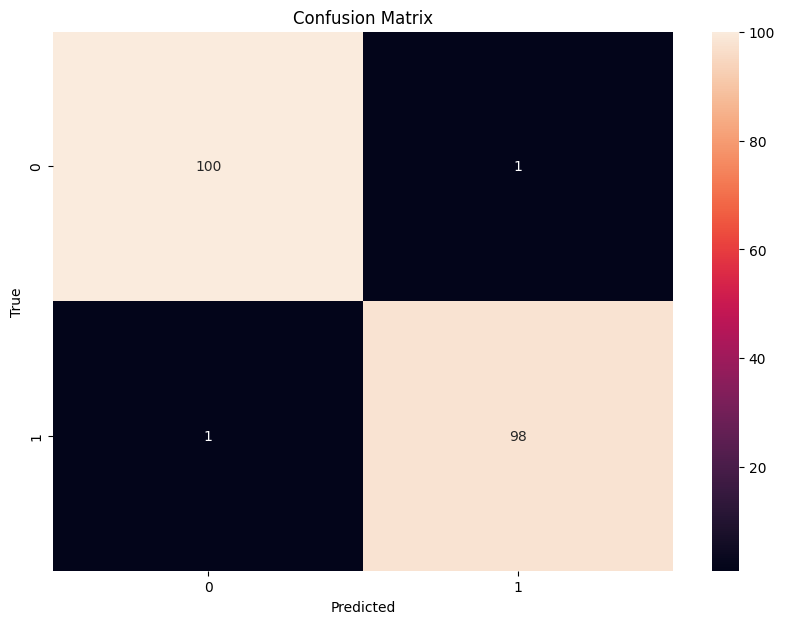

In [3]:
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = tokenized["test"]["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用seaborn绘制混淆矩阵的热力图
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 加载测试数据
test_data = pd.read_parquet("./datasets/FinQuestions_v2/test.parquet")

# 预测
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = test_data["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 找出预测错误的案例
wrong_predictions = test_data[predictions != true_labels]

# 打印预测错误的案例
for index, row in wrong_predictions.iterrows():
    print(f"True Label: {row['label']}, Predicted Label: {predictions[index]}, Text: {row['text']}")

  0%|          | 0/4 [00:00<?, ?it/s]

Confusion Matrix:
[[100   1]
 [  1  98]]
True Label: 0, Predicted Label: 1, Text: 怎样在西北街证券开户时输入东吴证券的客户号？
True Label: 1, Predicted Label: 0, Text: 生态环境建设行业的上游是什么行业？


In [5]:
text = "2024年3月18日基金走势如何？"

# classifier = pipeline("sentiment-analysis", model=output_dir+"/checkpoint-75")
# classifier(text)